In [1]:
# Projekt: Schlaganfall-Risiko – Explorative Datenanalyse
# --------------------------------------------
# Dieses Notebook enthält die explorative Datenanalyse (EDA)
# für einen Datensatz mit Patientendaten (Kaggle).
# Ziel: Erste Hypothesen prüfen, Datenqualität bewerten,
# Verteilungen und Zusammenhänge visualisieren.

In [2]:
# Bibliotheken laden
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

In [3]:
# CSV-Datei laden
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [4]:
# Struktur der Daten
# Der Datensatz umfasst 5110 Zeilen und 12 Spalten.
print(df.shape)

(5110, 12)


In [5]:
# Zeigt Spaltennamen, Datentypen, Anzahl nicht-leerer Einträge 
# und Anzahl der eindeutigen Werte
struktur_df = pd.DataFrame({
    "Spalte": df.columns,
    "Datentyp": df.dtypes.values,
    "Nicht-Null Werte": df.notnull().sum().values,
    "Anzahl eindeutiger Werte": df.nunique().values
})
struktur_df.style.set_caption("Struktur der Schlaganfall-Daten")

,Spalte,Datentyp,Nicht-Null Werte,Anzahl eindeutiger Werte
0,id,int64,5110,5110
1,gender,object,5110,3
2,age,float64,5110,104
3,hypertension,int64,5110,2
4,heart_disease,int64,5110,2
5,ever_married,object,5110,2
6,work_type,object,5110,5
7,Residence_type,object,5110,2
8,avg_glucose_level,float64,5110,3979
9,bmi,float64,4909,418


In [6]:
# ersten Überblick über den Aufbau des Datensatzes
print(df.head(10))
print(df.tail(10))

      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   
5  56669    Male  81.0             0              0          Yes   
6  53882    Male  74.0             1              1          Yes   
7  10434  Female  69.0             0              0           No   
8  27419  Female  59.0             0              0          Yes   
9  60491  Female  78.0             0              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private    

In [7]:
# Datenqualität prüfen: Fehlende Werte
print('Fehlende Werte:')
print(df.isnull().sum())

Fehlende Werte:
id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


In [8]:
# Datenqualität prüfen: Duplikate
print('Duplikate:')
print(df.duplicated().sum())

Duplikate:
0


In [9]:
# Univariate Analyse 
# Deskriptive Statistiken
df.describe() 

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [10]:
# Dataframe df mit kategorialen (object) Spalten
object_cols = df.select_dtypes(include='object').columns

# Leere Liste für alle Tabellen
descriptive_stats = []

for col in object_cols:
    value_counts = df[col].value_counts(dropna=False)
    percent = df[col].value_counts(normalize=True, dropna=False) * 100
    summary = pd.DataFrame({
        'Variable': [col]*len(value_counts),
        'Kategorie': value_counts.index,
        'Anzahl': value_counts.values,
        'Prozent': percent.round(2)
    })
    descriptive_stats.append(summary)

# Alles zusammenführen
kategorien_df = pd.concat(descriptive_stats, ignore_index=True)

# Prozentspalte als formatierten String
kategorien_df['Prozent'] = kategorien_df['Prozent'].astype(str) + '%'

# Ausgabe
kategorien_df.style.set_caption("Kategorien & Verteilung der kategorialen Variablen")

,Variable,Kategorie,Anzahl,Prozent
0,gender,Female,2994,58.59%
1,gender,Male,2115,41.39%
2,gender,Other,1,0.02%
3,ever_married,Yes,3353,65.62%
4,ever_married,No,1757,34.38%
5,work_type,Private,2925,57.24%
6,work_type,Self-employed,819,16.03%
7,work_type,children,687,13.44%
8,work_type,Govt_job,657,12.86%
9,work_type,Never_worked,22,0.43%


stroke
0    0.951262
1    0.048738
Name: proportion, dtype: float64


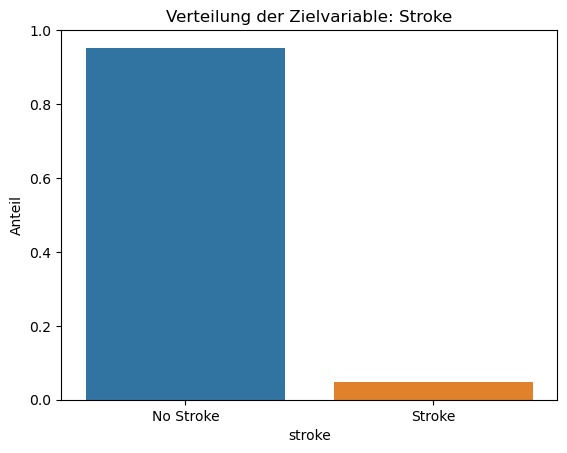

In [22]:
# Zielvariable: Stroke

# nur 5 % der Personen im Sample hatten Schlaganfall -> Imbalance
print(df['stroke'].value_counts(normalize=True))

stroke_counts = df['stroke'].value_counts(normalize=True)

colors = ['#1f77b4', '#ff7f0e']  # Blau für 0, Orange für 1

# Balkendiagramm zeichnen ohne FutureWarning
sns.barplot(
    x=stroke_counts.index,
    y=stroke_counts.values,
    hue=stroke_counts.index,       # x auch als hue verwenden
    palette=colors,
    legend=False                   # keine doppelte Legende
)
plt.xticks([0, 1], ['No Stroke', 'Stroke'])
plt.ylabel('Anteil')
plt.title('Verteilung der Zielvariable: Stroke')
plt.ylim(0, 1)
plt.show()

In [12]:
# Bereinigung der Daten

# Im Datensatz gibt es nur eine einzige Beobachtung mit der Angabe `gender` = `'Other'`. 
# Aufgrund der äußerst geringen Anzahl lässt sich diese Kategorie weder statistisch sinnvoll analysieren noch modelltechnisch zuverlässig berücksichtigen. 
# Aus diesem Grund wird diese Beobachtung aus dem Datensatz entfernt.
df = df[df['gender'] != 'Other']
df = df.drop(columns=['id'])

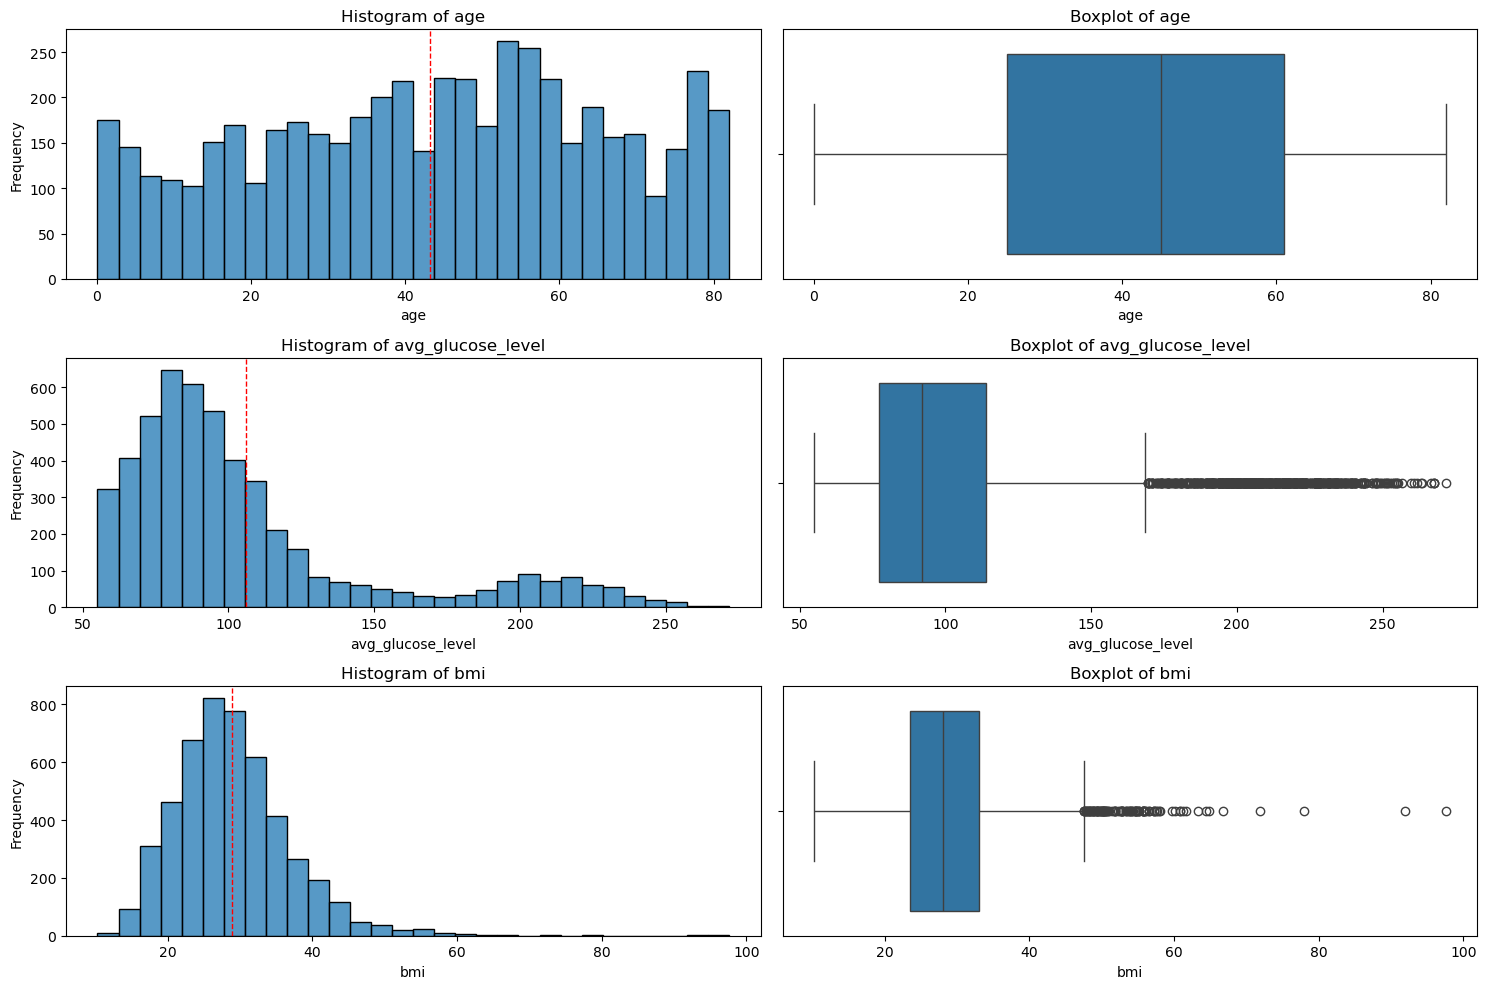

In [13]:
# Identifizierung von Ausreißern

numeric_columns = ['age', 'avg_glucose_level', 'bmi']

# Plot erstellen für numerische Spalten
plt.figure(figsize=(15, 10))

for i, column in enumerate(numeric_columns):
    plt.subplot(len(numeric_columns), 2, i * 2 + 1)
    sns.histplot(df[column], bins=30, kde=False)
    plt.axvline(df[column].mean(), color='red', linestyle='dashed', linewidth=1)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

    plt.subplot(len(numeric_columns), 2, i * 2 + 2)
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)

plt.tight_layout()
plt.show()

In [14]:
# Bivariate Analyse

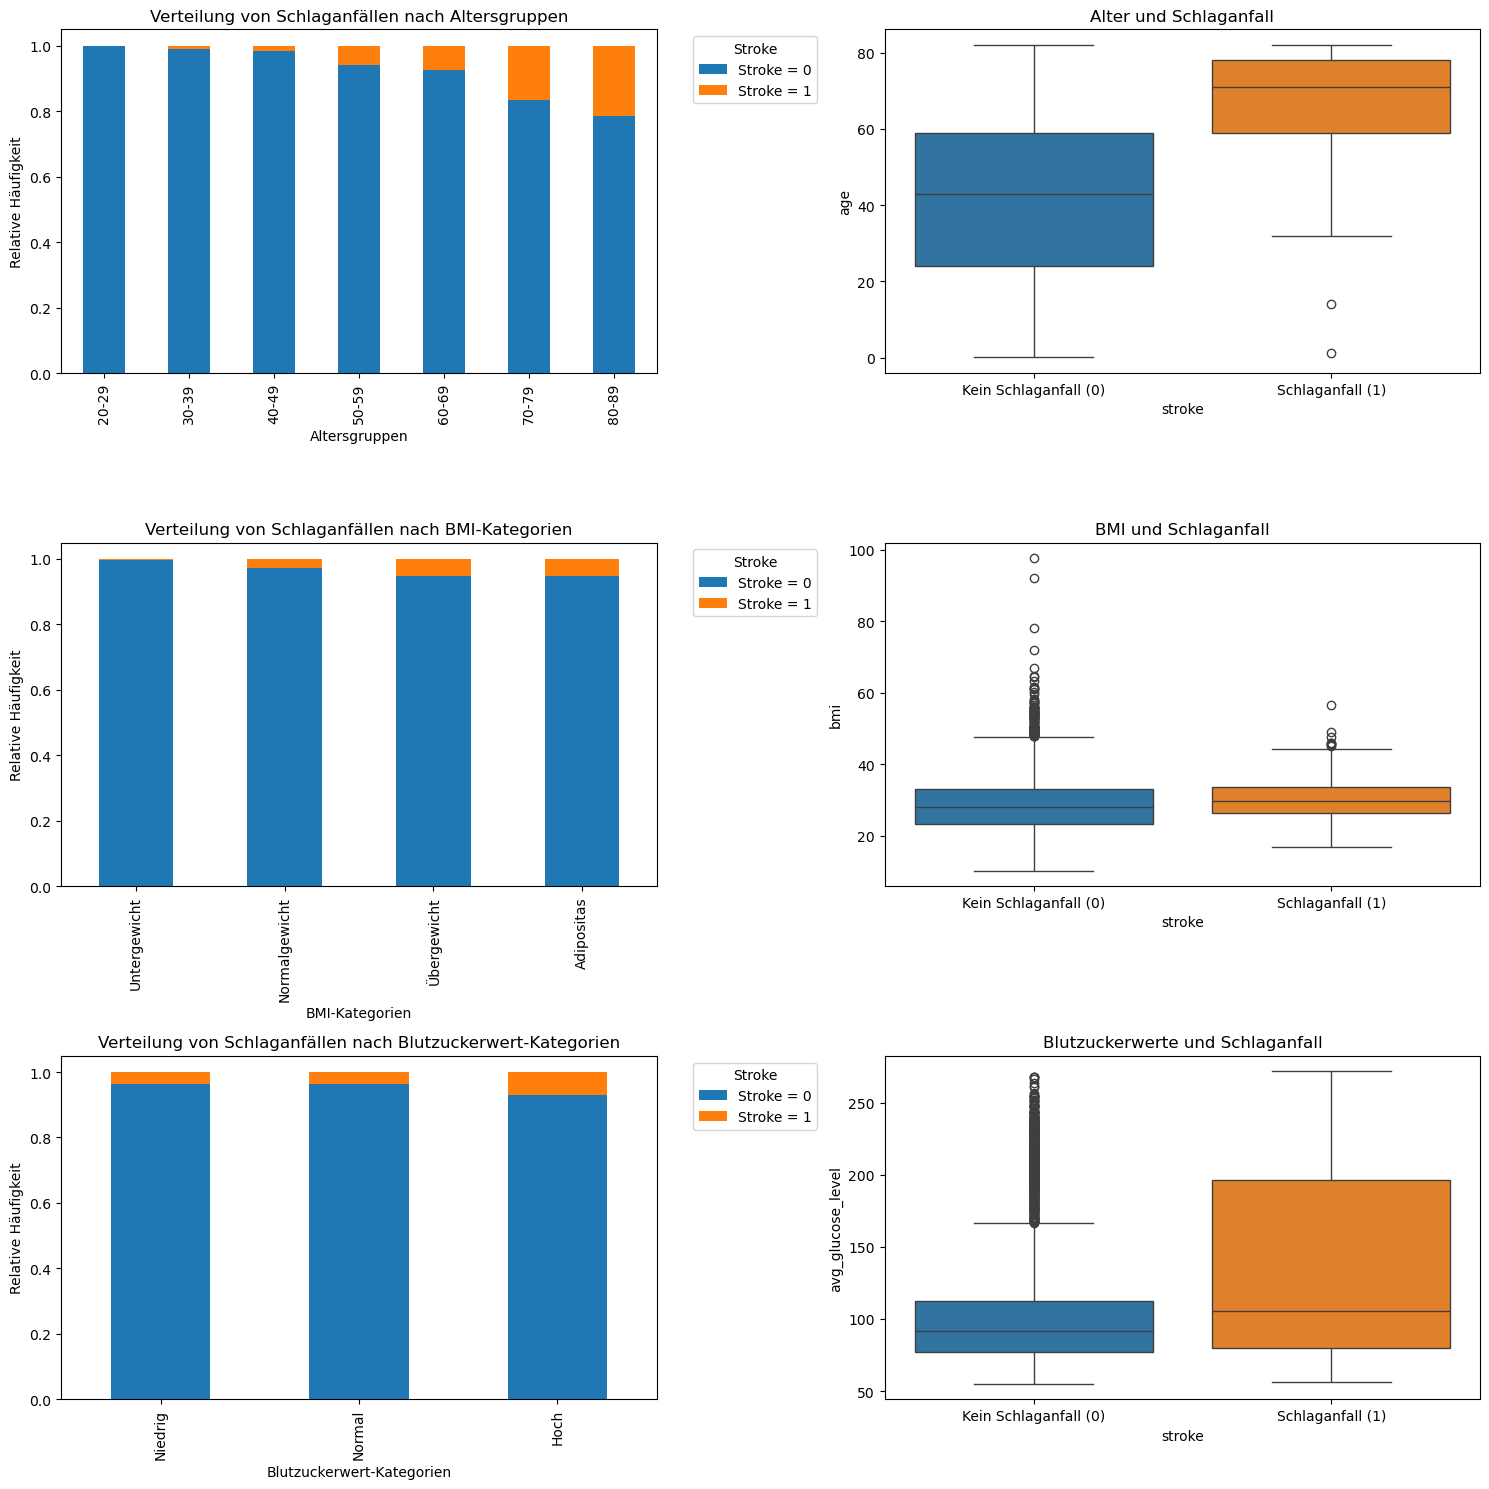

In [15]:
# Kopie des df erstellen
df_copy = df.copy()
# Altersgruppen erstellen
bins_age = range(20, 100, 10)  # 20-29, 30-39, ..., 90-99
labels_age = [f'{i}-{i+9}' for i in bins_age[:-1]]
df_copy['age_group'] = pd.cut(df_copy['age'], bins=bins_age, labels=labels_age, right=False)

# Relative Häufigkeiten für Altersgruppen berechnen
relative_counts_age = df_copy.groupby(['age_group', 'stroke'], observed=False).size().unstack(fill_value=0)
relative_counts_age = relative_counts_age.div(relative_counts_age.sum(axis=1), axis=0)

# BMI-Kategorisierung
def categorize_bmi(bmi):
    if pd.isna(bmi):
        return None
    elif bmi < 18.5:
        return 'Untergewicht'
    elif 18.5 <= bmi < 25:
        return 'Normalgewicht'
    elif 25 <= bmi < 30:
        return 'Übergewicht'
    else:
        return 'Adipositas'

df_copy['bmi_category'] = df_copy['bmi'].apply(categorize_bmi)

# Relative Häufigkeiten für BMI berechnen
relative_counts_bmi = df_copy.groupby(['bmi_category', 'stroke'], observed=False).size().unstack(fill_value=0)
relative_counts_bmi = relative_counts_bmi.div(relative_counts_bmi.sum(axis=1), axis=0)

# Blutzuckerwert-Kategorisierung
def categorize_glucose(glucose):
    if glucose < 70:
        return 'Niedrig'
    elif 70 <= glucose < 100:
        return 'Normal'
    else:
        return 'Hoch'

df_copy['glucose_category'] = df_copy['avg_glucose_level'].apply(categorize_glucose)

# Relative Häufigkeiten für Blutzuckerwerte berechnen
relative_counts_glucose = df_copy.groupby(['glucose_category', 'stroke'], observed=False).size().unstack(fill_value=0)
relative_counts_glucose = relative_counts_glucose.div(relative_counts_glucose.sum(axis=1), axis=0)

# Sortierung der Kategorien
bmi_order = ['Untergewicht', 'Normalgewicht', 'Übergewicht', 'Adipositas']
glucose_order = ['Niedrig', 'Normal', 'Hoch']
relative_counts_bmi = relative_counts_bmi.reindex(bmi_order)
relative_counts_glucose = relative_counts_glucose.reindex(glucose_order)

# Farben definieren
colors = ['#1f77b4', '#ff7f0e']  # Blau für 0, Orange für 1

# Subplots erstellen
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

# Altersgruppen Plot
relative_counts_age.plot(kind='bar', stacked=True, ax=axs[0, 0])
axs[0, 0].set_title('Verteilung von Schlaganfällen nach Altersgruppen')
axs[0, 0].set_xlabel('Altersgruppen')
axs[0, 0].set_ylabel('Relative Häufigkeit')
axs[0, 0].legend(title='Stroke', labels=['Stroke = 0', 'Stroke = 1'], bbox_to_anchor=(1.05, 1), loc='upper left')

# Altersgruppen Boxplot
#sns.boxplot(x='stroke', y='age', data=df, palette=colors, ax=axs[0, 1])
sns.boxplot(x='stroke', y='age', hue='stroke', data=df_copy, palette=colors, ax=axs[0, 1], legend=False)
axs[0, 1].set_title('Alter und Schlaganfall')
axs[0, 1].set_xticks([0, 1])
axs[0, 1].set_xticklabels(['Kein Schlaganfall (0)', 'Schlaganfall (1)'])

# BMI Plot
relative_counts_bmi.plot(kind='bar', stacked=True, ax=axs[1, 0])
axs[1, 0].set_title('Verteilung von Schlaganfällen nach BMI-Kategorien')
axs[1, 0].set_xlabel('BMI-Kategorien')
axs[1, 0].set_ylabel('Relative Häufigkeit')
axs[1, 0].legend(title='Stroke', labels=['Stroke = 0', 'Stroke = 1'], bbox_to_anchor=(1.05, 1), loc='upper left')

# BMI Boxplot
#sns.boxplot(x='stroke', y='bmi', data=df, palette=colors, ax=axs[1, 1])
sns.boxplot(x='stroke', y='bmi', hue='stroke', data=df_copy, palette=colors, ax=axs[1, 1], legend=False)
axs[1, 1].set_title('BMI und Schlaganfall')
axs[1, 1].set_xticks([0, 1])
axs[1, 1].set_xticklabels(['Kein Schlaganfall (0)', 'Schlaganfall (1)'])

# Blutzuckerwerte Plot
relative_counts_glucose.plot(kind='bar', stacked=True, ax=axs[2, 0])
axs[2, 0].set_title('Verteilung von Schlaganfällen nach Blutzuckerwert-Kategorien')
axs[2, 0].set_xlabel('Blutzuckerwert-Kategorien')
axs[2, 0].set_ylabel('Relative Häufigkeit')
axs[2, 0].legend(title='Stroke', labels=['Stroke = 0', 'Stroke = 1'], bbox_to_anchor=(1.05, 1), loc='upper left')

# Blutzucker Boxplot
#sns.boxplot(x='stroke', y='avg_glucose_level', data=df, palette=colors, ax=axs[2, 1])
sns.boxplot(x='stroke', y='avg_glucose_level', hue='stroke', data=df_copy, palette=colors, ax=axs[2, 1], legend=False)
axs[2, 1].set_title('Blutzuckerwerte und Schlaganfall')
axs[2, 1].set_xticks([0, 1])
axs[2, 1].set_xticklabels(['Kein Schlaganfall (0)', 'Schlaganfall (1)'])

plt.tight_layout()
plt.show()

In [16]:
# Kreuztabellen: kategoriale Variablen und Stroke

def kreuztabelle(spalte):
    # Kreuztabelle zwischen spalte und 'stroke' (absolute Häufigkeiten)
    kreuztab_abs = pd.crosstab(df[spalte], df['stroke'])

    # Prozentwerte bezogen auf die Zeilen (also pro Kategorie in spalte)
    kreuztab_rel = pd.crosstab(df[spalte], df['stroke'], normalize='index') * 100

    # Kombiniere absolute Werte und Prozentwerte als String in einer Tabelle
    kreuztab_combined = kreuztab_abs.astype(str) + " (" + kreuztab_rel.round(1).astype(str) + "%)"

    print('Krezutabelle: Stroke und',spalte)
    print(kreuztab_combined)

kreuztabelle('gender')
kreuztabelle('ever_married')
kreuztabelle('work_type')
kreuztabelle ('Residence_type')
kreuztabelle('smoking_status')

Krezutabelle: Stroke und gender
stroke             0           1
gender                          
Female  2853 (95.3%)  141 (4.7%)
Male    2007 (94.9%)  108 (5.1%)
Krezutabelle: Stroke und ever_married
stroke                   0           1
ever_married                          
No            1727 (98.3%)   29 (1.7%)
Yes           3133 (93.4%)  220 (6.6%)
Krezutabelle: Stroke und work_type
stroke                    0           1
work_type                              
Govt_job        624 (95.0%)   33 (5.0%)
Never_worked    22 (100.0%)    0 (0.0%)
Private        2775 (94.9%)  149 (5.1%)
Self-employed   754 (92.1%)   65 (7.9%)
children        685 (99.7%)    2 (0.3%)
Krezutabelle: Stroke und Residence_type
stroke                     0           1
Residence_type                          
Rural           2399 (95.5%)  114 (4.5%)
Urban           2461 (94.8%)  135 (5.2%)
Krezutabelle: Stroke und smoking_status
stroke                      0          1
smoking_status                          
U

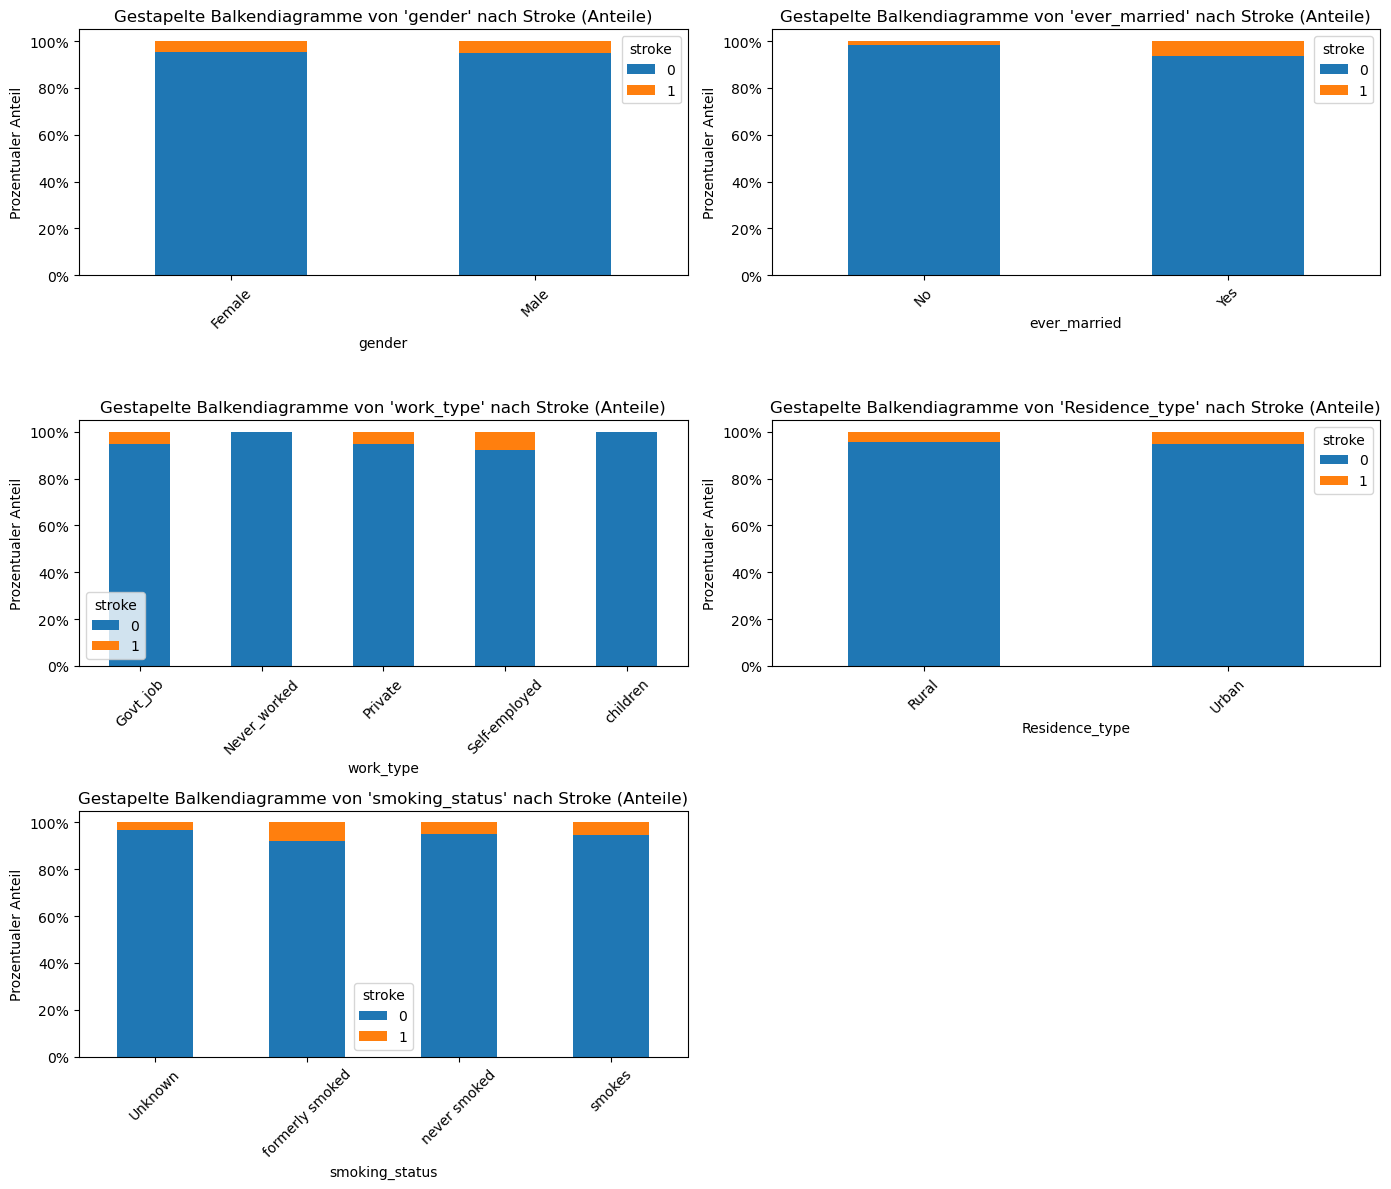

In [17]:
# Visualisierungen
categorical_cols = df.select_dtypes(include='object').columns

# Anzahl der Subplots
num_cols = 2
num_rows = (len(categorical_cols) + num_cols - 1) // num_cols  # Berechnung der benötigten Zeilen

# Subplots erstellen
fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 4 * num_rows))
axes = axes.flatten()  # Flache Liste der Achsen

for i, col in enumerate(categorical_cols):
    # Kreuztabelle mit Prozentwerten pro Kategorie (Index)
    ct = pd.crosstab(df[col], df['stroke'], normalize='index')

    # Plot als gestapeltes Balkendiagramm
    ct.plot(kind='bar', stacked=True, ax=axes[i])

    axes[i].set_title(f"Gestapelte Balkendiagramme von '{col}' nach Stroke (Anteile)")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Prozentualer Anteil')
    axes[i].tick_params(axis='x', rotation=45)

    # Prozentwerte als y-Achse sind in [0,1], also in %
    axes[i].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}%'.format(y * 100)))

# Leere Subplots ausblenden, falls nötig
for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

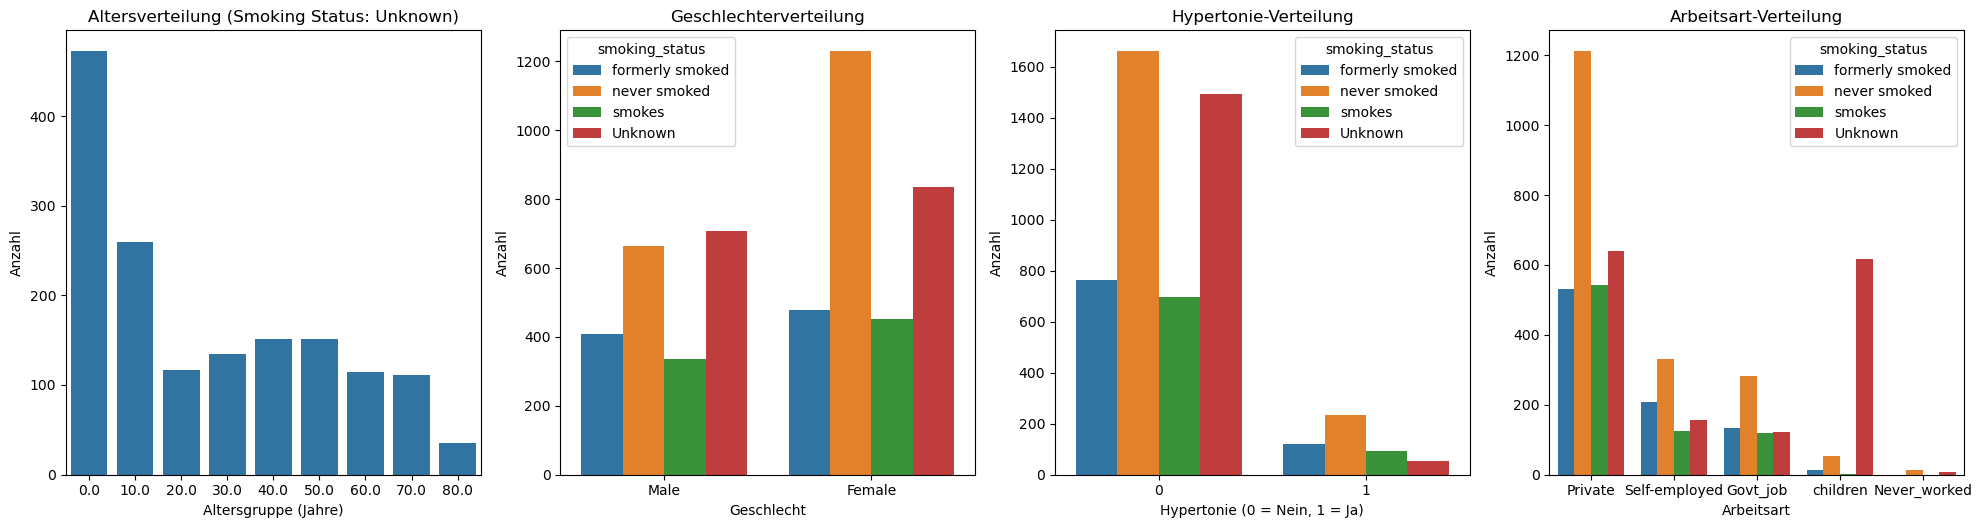

In [18]:
# Smoking_Status = "Unknown"

# Schritt 1: Altersverteilung für smoking_status 'unknown'
df_copy['age_group'] = (df_copy['age'] // 10) * 10

plt.figure(figsize=(20, 15))

# Altersverteilung für smoking_status 'unknown'
plt.subplot(3, 4, 1)
sns.countplot(data=df_copy[df_copy['smoking_status'] == 'Unknown'], x='age_group')
plt.title('Altersverteilung (Smoking Status: Unknown)')
plt.xlabel('Altersgruppe (Jahre)')
plt.ylabel('Anzahl')

# Geschlechterverteilung
plt.subplot(3, 4, 2)
sns.countplot(data=df_copy, x='gender', hue='smoking_status')
plt.title('Geschlechterverteilung')
plt.xlabel('Geschlecht')
plt.ylabel('Anzahl')

# Hypertonie-Verteilung
plt.subplot(3, 4, 3)
sns.countplot(data=df_copy, x='hypertension', hue='smoking_status')
plt.title('Hypertonie-Verteilung')
plt.xlabel('Hypertonie (0 = Nein, 1 = Ja)')
plt.ylabel('Anzahl')

# Arbeitsart-Verteilung
plt.subplot(3, 4, 4)
sns.countplot(data=df_copy, x='work_type', hue='smoking_status')
plt.title('Arbeitsart-Verteilung')
plt.xlabel('Arbeitsart')
plt.ylabel('Anzahl')

plt.tight_layout()
plt.show()

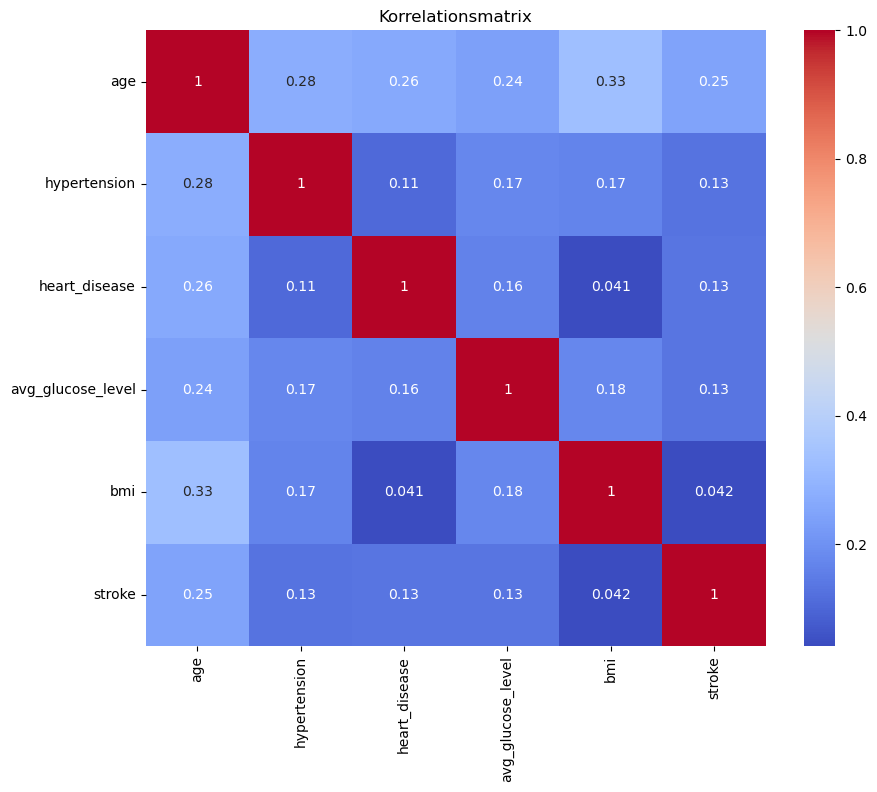

In [19]:
# Korrelationen
corr = df.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Korrelationsmatrix')
plt.show()

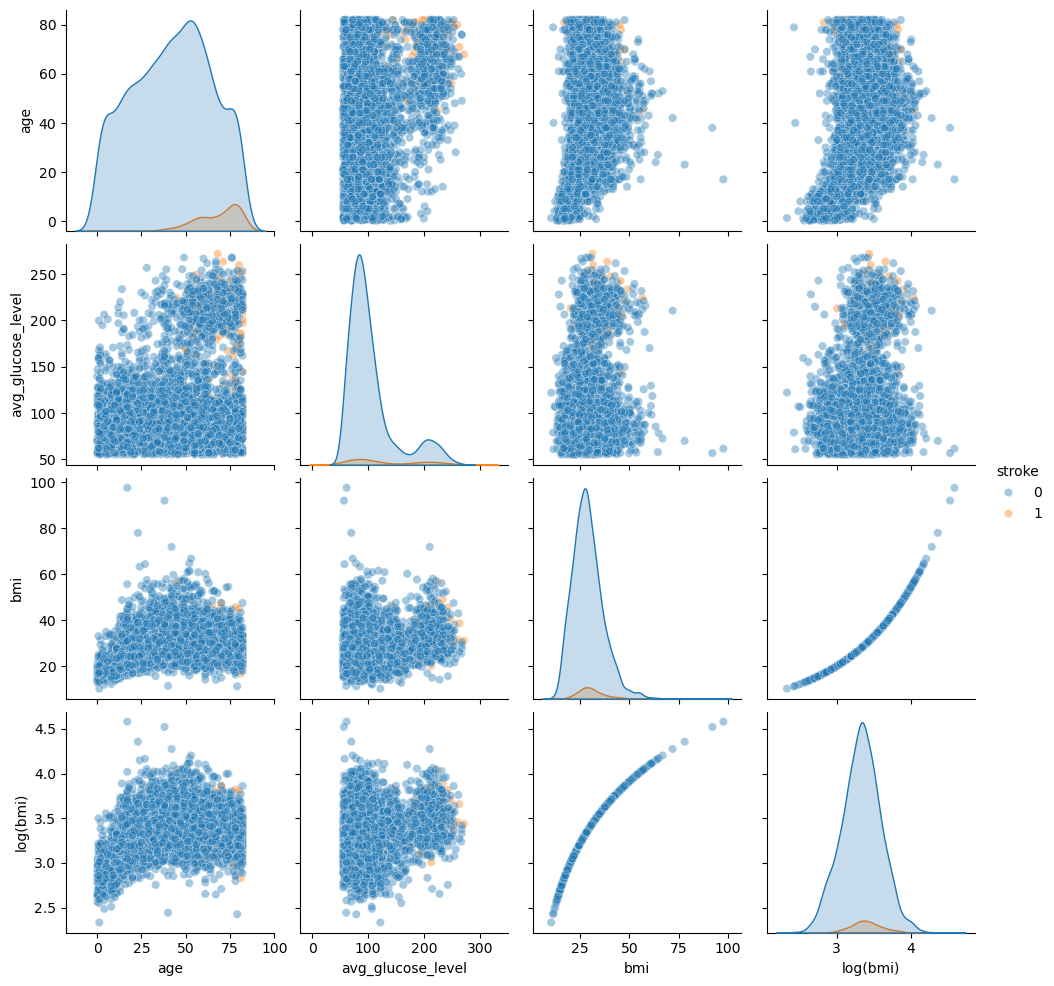

In [20]:
# Scatterplots
X = df.select_dtypes(include=["float"])
X["stroke"] = df["stroke"]
X["log(bmi)"] = np.log(X["bmi"])
sns.pairplot(X, hue="stroke", plot_kws={"alpha": 0.4})

In [21]:
# Kopie des Dataframes zur Sicherung
df_kopie = df.copy()
df_kopie.to_csv('df_aufbereitet.csv', index=False)